In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder as OneHotEncoder
import datetime
import seaborn as sns
import sklearn.preprocessing as pp

%load_ext autoreload
%autoreload 2
from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import ticket sales data

In [2]:
df_tick = pd.DataFrame.from_csv('data/ticket_sales.csv', index_col = 0, parse_dates = True)

remove the zip codes that are nonsense, and remove the last 4 digits for the ones in the 33333-3333 format

^ means this is the begining of the string - nothing can come before it
() is one matching group 
\d{5} means 5 numerical digits
\- means that it contains a dash
? means the second matching group is optional
$ means that has to be the end of the string

`.str.extract()` is the pandas regular expression handler, and it makes columns out of regular expression matching groups

In [3]:
df_tick['zip_clean'] = df_tick.zip_code.str.extract('^(\d{5})(\-\d{4})?$').loc[:,0]

Create a 'state' column fromt the zipcodes.

In [4]:
df_tick['state'] = df_tick.zip_clean.map(convert_zip)

Create columns that declare whether the purchaser is a CO resident or not.

In [5]:
df_tick['is_CO'] = df_tick.state.map(lambda state: 1 if state == 'CO' else 0)
df_tick['not_CO'] = df_tick.state.map(lambda state: 1 if (state != 'CO' and not pd.isnull(state)) else 0)

In [6]:
df_tick.head()

,zip_code,tickets,zip_clean,state,is_CO,not_CO
Date,,,,,,
2014-10-31,3215,16,NaN,NaN,0,0
2014-10-31,3287,1,NaN,NaN,0,0
2014-10-31,3304,2,NaN,NaN,0,0
2014-10-31,12518,2,12518,NY,0,1
2014-10-31,2095,1,NaN,NaN,0,0


Resample the data so that it only has one row per day.

In [7]:
resamp_time = '1440Min'
df_tick_day = df_tick.resample(resamp_time, how = sum)

In [8]:
df_tick_day.head()

,tickets,is_CO,not_CO
Date,,,
2014-10-31,77,27,10
2014-11-01,64,14,21
2014-11-02,79,18,11
2014-11-03,35,9,10
2014-11-04,38,13,7


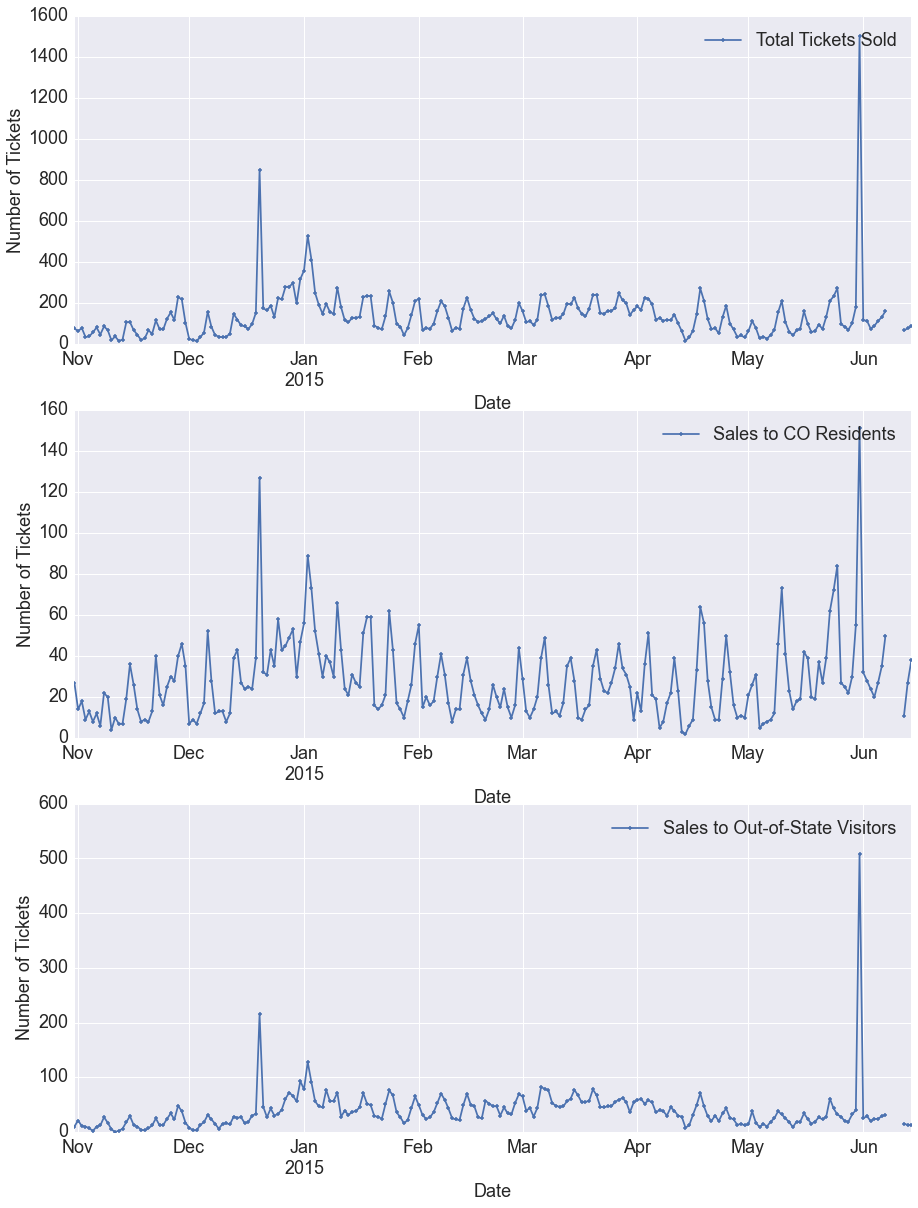

In [9]:
plot_ticket_sales(df_tick_day)

Import search volume data

In [10]:
df_search = pd.DataFrame.from_csv('data/search_vol.csv', index_col = 0, parse_dates = True)

Resample the data to one row per day and combine the two dataframes

In [11]:
resamp_time = '1440Min'
df_all_lift = pd.concat([df_tick_day, df_search], axis=1).dropna()

Create a "day of week" column.

In [12]:
df_all_lift = create_day_of_week_col(df_all_lift)

Create a list of features.

In [13]:
features = list(df_all_lift)

In [14]:
df_all_lift = df_all_lift.dropna()

In [15]:
def pp_standard_scaler(X):
    standard_scale = pp.StandardScaler()
    standard_scale_fit = standard_scale.fit(X)
    return standard_scale_fit.transform(X), standard_scale_fit

In [22]:
df_scaled_array, standard_scale_fit = pp_standard_scaler(df_all_lift)
df_scaled = pd.DataFrame(df_scaled_array, columns = features)
index_col = df.index
df_scaled.set_index(index_col, inplace = True)
#df_scaled = df_prescaled[features].apply(df_scaled_array)
df_sc = pd.concat([df_scaled, df[ref_column]], axis = 1) 

NameError: name 'df' is not defined

Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b92c490>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x109002990>]], dtype=object)

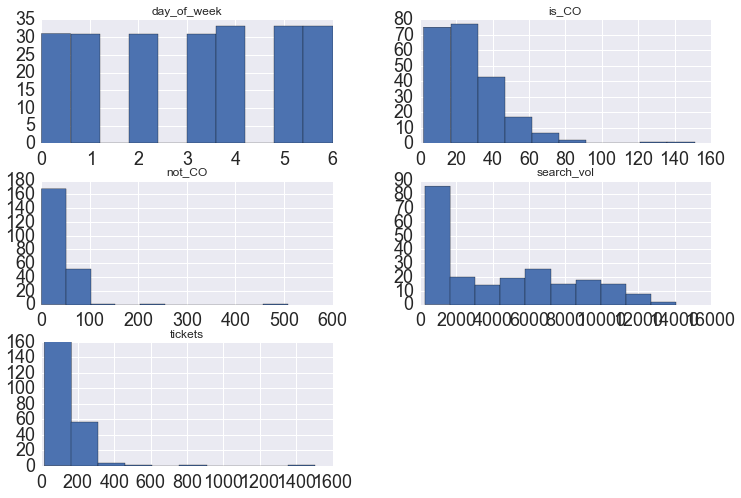

In [16]:
df_all_lift.hist()

Plot the site visit data.

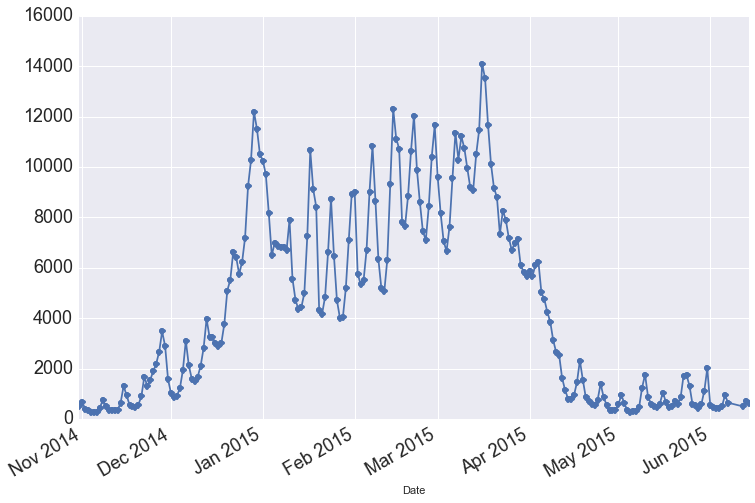

In [17]:
df_all_lift.search_vol.plot(marker = 'o')

Plot the ticket purchase data.

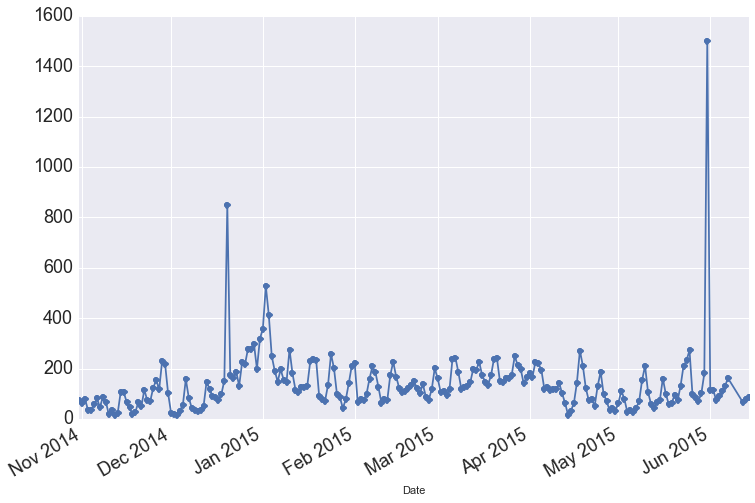

In [18]:
df_all_lift.tickets.plot(marker = 'o')

Look at the correlations between variables.

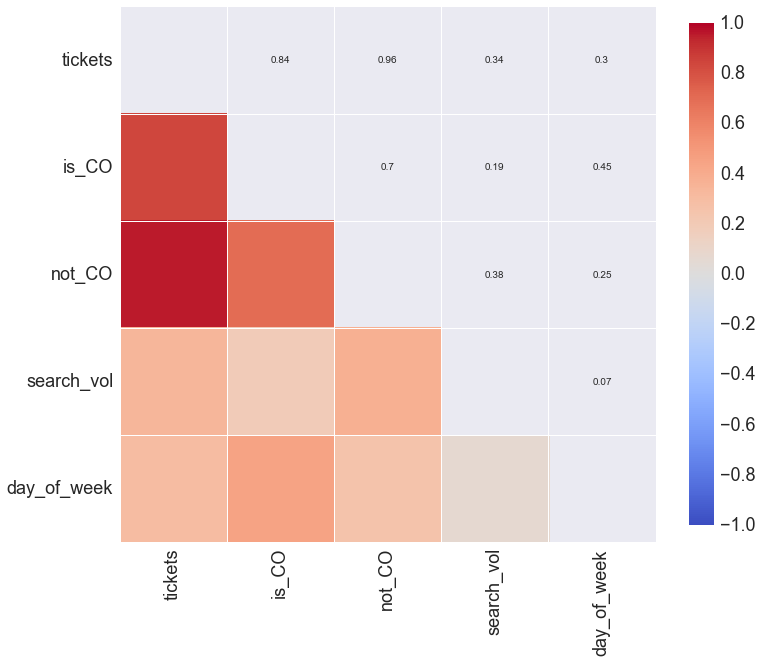

In [21]:
make_correlation_plot(df_all_lift)

Try shifting search volume back 1-7 days and make another correlation plot. 
IDEAS: 
1) Create features for area under search curve for different numbers of days/weeks before.
2) Create features for slope of for different numbers of days/weeks before. (How does this change with snow predictions)?
3) Create features combining searches and 

In [22]:
df_all_lift['search*day'] = df_all_lift.search_vol * df_all_lift.day_of_week

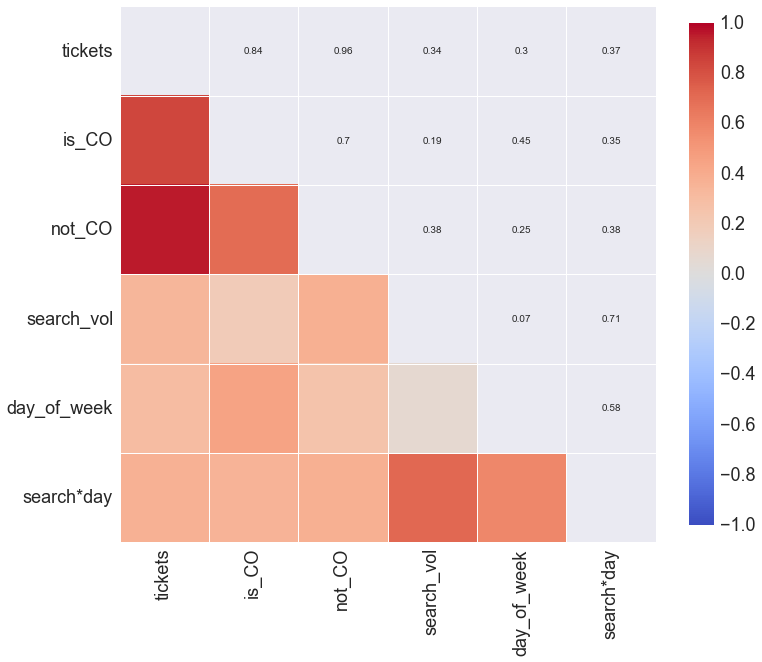

In [23]:
make_correlation_plot(df_all_lift)

In [24]:
df_all_lift.to_csv('data/cleaned_ticket_data.csv')